# Setup

### Import libraries

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

### Prepare the datasets

In [2]:
CLASSES = ['Corrosionstain', 'Cracks', 'Exposedbars', 'Spalling']

TRAIN_DIR = "BiNet_Dataset/training"
VAL_DIR = "BiNet_Dataset/validation"
TEST_DIR = "BiNet_Dataset/testing"

### Set GPU memory growth

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Create Generators

In [4]:
scale_gen = ImageDataGenerator(
    rescale=1.0/255,
)

In [5]:
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 32

train_generator = scale_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = scale_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = scale_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2428 images belonging to 4 classes.
Found 347 images belonging to 4 classes.
Found 696 images belonging to 4 classes.


# Model Training

### Create Model

In [6]:
# Trial 1: Baseline Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734158068.318180    3086 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### Model Summary

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,258,564 (62.02 MB)

 Trainable params: 16,258,564 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

### Fit Model

In [8]:
model_hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1734158070.023108    3314 service.cc:148] XLA service 0x7ff90000aed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734158070.023339    3314 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-14 14:34:30.057068: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734158070.170549    3314 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/76 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5503 - loss: 14.5483

I0000 00:00:1734158071.655882    3314 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 197ms/step - accuracy: 0.3996 - loss: 8.7561 - val_accuracy: 0.5937 - val_loss: 0.9836
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.6654 - loss: 0.8941 - val_accuracy: 0.6744 - val_loss: 0.8870
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7785 - loss: 0.6666 - val_accuracy: 0.6772 - val_loss: 0.8507
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.8466 - loss: 0.4683 - val_accuracy: 0.7349 - val_loss: 0.8249
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9057 - loss: 0.3193 - val_accuracy: 0.6974 - val_loss: 0.9921
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.9223 - loss: 0.2582 - val_accuracy: 0.7118 - val_loss: 0.9423
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9566 - loss: 0.1779 - val_accuracy: 0.6888 - val_loss: 1.2915
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9705 - loss: 0.1321 - val_accuracy: 0.6945 - 

### Evaluate Model

In [29]:
def plot_training_history(history):
    """
    Plot the training history of the model using Seaborn.

    Parameters:
    - history: History object containing the training history.

    Returns:
    - None (displays the plots)
    """
    
    # Extracting data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Creating DataFrames for plotting
    epochs = range(1, len(acc) + 1)
    
    # Data for accuracy
    acc_data = {
        'Epoch': list(epochs) * 2,
        'Value': acc + val_acc,
        'Metric': ['Training Accuracy'] * len(acc) + ['Validation Accuracy'] * len(val_acc)
    }
    acc_df = pd.DataFrame(acc_data)

    # Data for loss
    loss_data = {
        'Epoch': list(epochs) * 2,
        'Value': loss + val_loss,
        'Metric': ['Training Loss'] * len(loss) + ['Validation Loss'] * len(val_loss)
    }
    loss_df = pd.DataFrame(loss_data)

    # Creating side-by-side plots
    plt.figure(figsize=(12, 4))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(data=acc_df, x='Epoch', y='Value', hue='Metric', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(data=loss_df, x='Epoch', y='Value', hue='Metric', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


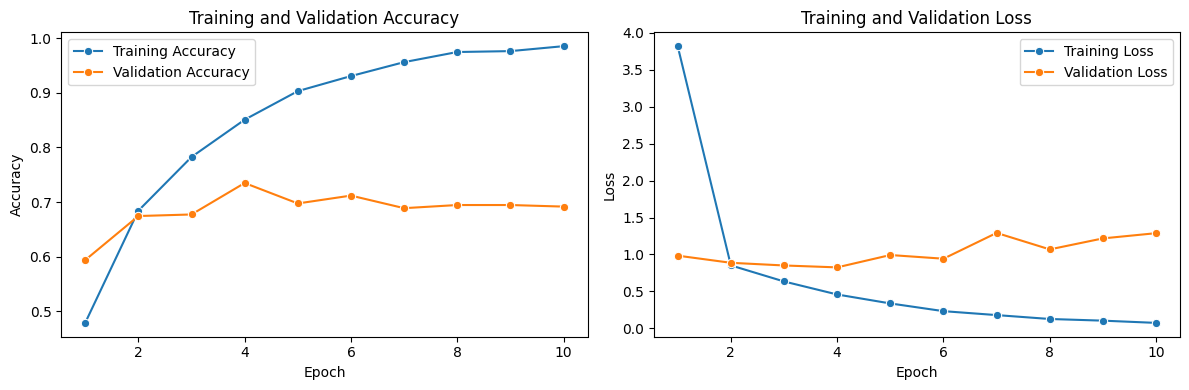

In [30]:
plot_training_history(model_hist)

In [13]:
model.evaluate(test_generator)

/home/arbovitae/miniconda3/envs/tf218/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.8232 - loss: 0.7385


[1.0714378356933594, 0.7543103694915771]

In [51]:
def plot_predictions(model, test_generator, classes, num_images=32, grid_shape=(4, 8)):
    """
    Plots a grid of images from the test generator with their true and predicted labels.
    Labels are colored green if the prediction is correct, and red otherwise.

    Parameters:
    - model: Trained Keras model for predictions.
    - test_generator: A Keras ImageDataGenerator iterator for the test set.
    - classes: List of class names corresponding to the model's output.
    - num_images: Number of images to display. Default is 32.
    - grid_shape: Tuple defining the grid layout (rows, cols). Default is (4, 8).
    """
    # Get a batch of images and true labels from the test generator
    images, true_labels = next(test_generator)
    true_labels_indices = np.argmax(true_labels, axis=1)  # Convert one-hot to class indices

    # Predict the labels for the batch of images
    predicted_labels = model.predict(images)
    predicted_labels_indices = np.argmax(predicted_labels, axis=1)

    # Define a helper function to get the label and its color
    def get_label_color(true_idx, pred_idx):
        label_name = classes[true_idx]
        pred_name = classes[pred_idx]
        color = "green" if true_idx == pred_idx else "red"
        return f"{pred_name}", label_name, color

    # Determine grid size
    rows, cols = grid_shape
    total_slots = rows * cols
    num_images = min(num_images, total_slots, len(images))  # Adjust based on available images

    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= num_images:  # Disable unused axes
            ax.axis('off')
            continue

        pred_name, label_name, color = get_label_color(true_labels_indices[i], predicted_labels_indices[i])

        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(f"Class: {label_name}\n Prediction:{pred_name}", color=color, fontsize=10)

    plt.tight_layout()
    plt.show()

# Example Usage:
# Replace 'your_model.h5' with the actual path to your model
# model = load_model('your_model.h5')
# plot_predictions(model, test_generator, CLASSES, num_images=32, grid_shape=(4, 8))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


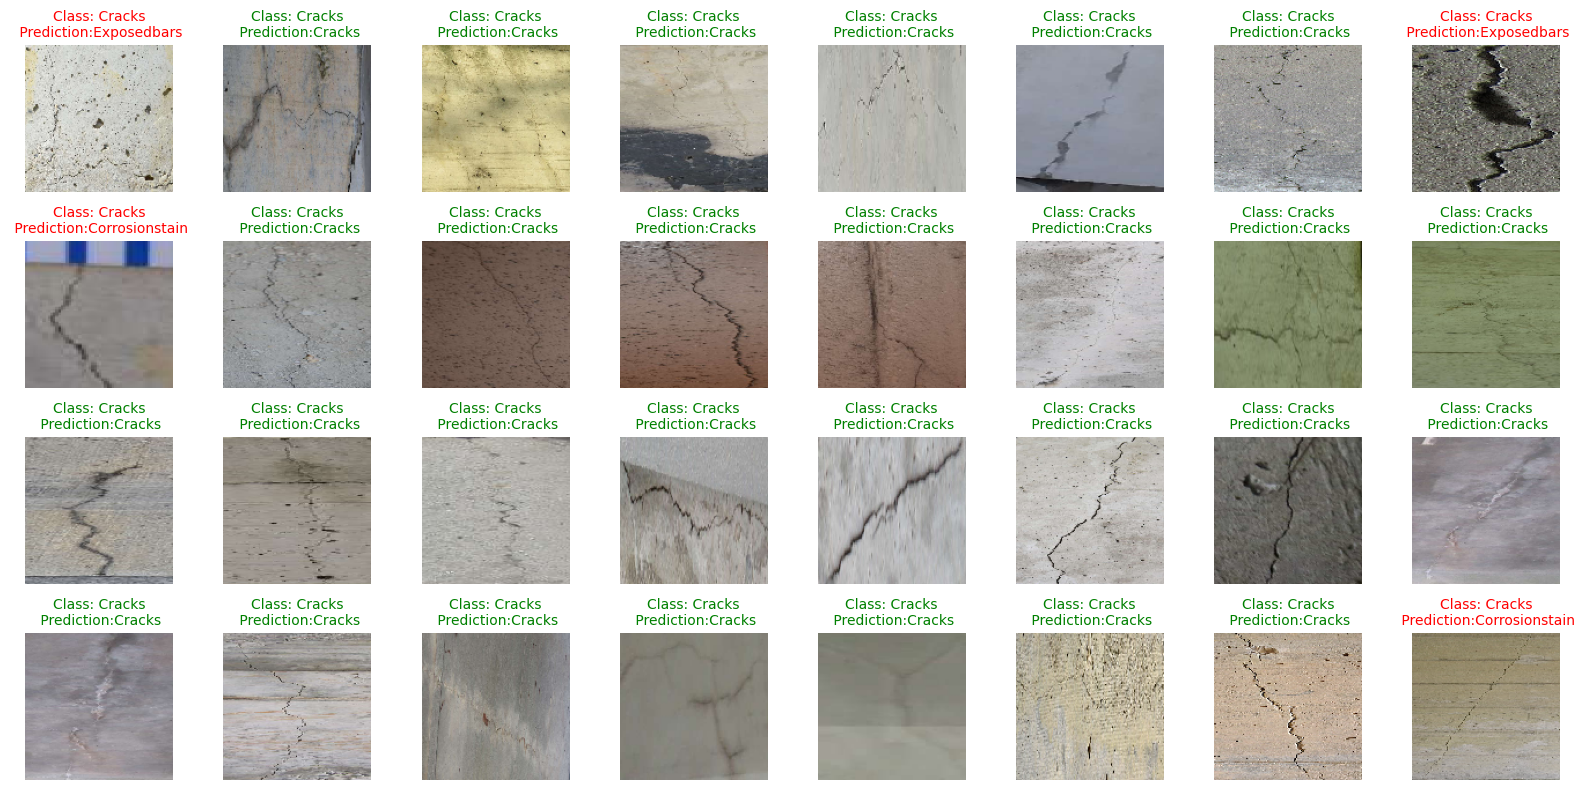

In [57]:
plot_predictions(model, test_generator, CLASSES, num_images=32, grid_shape=(4, 8))